## Data Loading

In [1]:
import pandas as pd
import numpy as np

In [2]:
#This is where we have stored the csv files:
#path = data/Supply Chain data 01

#reading features.csv inside the path
features = pd.read_csv('data/Supply Chain data 01/features.csv')
#reading stores.csv inside the path
stores = pd.read_csv('data/Supply Chain data 01/stores.csv')
#reading train.csv inside the path
train = pd.read_csv('data/Supply Chain data 01/train.csv')
#reading test.csv inside the path
test = pd.read_csv('data/Supply Chain data 01/test.csv')

# Display the first few rows of each dataframe to verify successful loading
print("Data Loaded Successfully.\n")
print("Features DataFrame:")
print(features.head())
print("\nStores DataFrame:")
print(stores.head())
print("\nTrain DataFrame:")
print(train.head())
print("\nTest DataFrame:")
print(test.head())

# Check the shapes of the dataframes
print("\nShapes of the DataFrames:")
print(f"Features: {features.shape}")
print(f"Stores: {stores.shape}")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

# Check for missing values in each dataframe
print("\nMissing values in each DataFrame:")
print(f"Features:\n{features.isnull().sum()}")
print(f"Stores:\n{stores.isnull().sum()}")
print(f"Train:\n{train.isnull().sum()}")
print(f"Test:\n{test.isnull().sum()}")  

# Display data types of each dataframe
print("\nData types of each DataFrame:")
print(f"Features:\n{features.dtypes}")
print(f"Stores:\n{stores.dtypes}")
print(f"Train:\n{train.dtypes}")
print(f"Test:\n{test.dtypes}")  

# Display descriptive statistics for numerical columns in each dataframe
print("\nDescriptive statistics for each DataFrame:")
print(f"Features:\n{features.describe()}")
print(f"Stores:\n{stores.describe()}")
print(f"Train:\n{train.describe()}")
print(f"Test:\n{test.describe()}")

Data Loaded Successfully.

Features DataFrame:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  

Stores DataFrame:
   Store Type    Size
0      1    A  151315
1      2    A  2023

## Part I - To compare forecasting at smallest unit level vs forecasting at aggregate level like store or department and then deaggregate to item level

The smallest level available is the Department level inside stores.csv. So:
Unit level is (Store, Dept) time series of Weekly_Sales
Aggregate level is (Store) total weekly sales across all departments. 

So Method 1 is forecast each (Store, Dept) series directly and produce X_1 forecasts per department. 

Method 2 is:
1. Aggregate dept sales to Store Total (A_2).
2. Forecast Store Total sales (F_2) to produce Y
3. Splity Y back into dept forecasts (D_2) to produce X_2

And then compare X_1 vs X_2 at dept level to see which is better. 

For Part I, we only need (Store, Dept, Date, Weekly_Sales) from train.csv. 
features.csv is not needed because we're using TSE which is univariate. 

In [3]:
#parse Date to datetime format
train['Date'] = pd.to_datetime(train['Date'])

#sort by store, dept, date
train = train.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

#Confirm weekly frequency of the data
train_dates = train['Date'].drop_duplicates().sort_values()
date_diffs = train_dates.diff().dropna()
print("\nDate differences to confirm weekly frequency:")
print(date_diffs.value_counts())


Date differences to confirm weekly frequency:
Date
7 days    142
Name: count, dtype: int64


In [4]:
#Choosing the test window as last 4 weeks

#last 4 unique dates
last_4_dates = sorted(train_dates.tail(4).tolist())
print("\nLast 4 unique dates for test window:")
print(last_4_dates)


Last 4 unique dates for test window:
[Timestamp('2012-10-05 00:00:00'), Timestamp('2012-10-12 00:00:00'), Timestamp('2012-10-19 00:00:00'), Timestamp('2012-10-26 00:00:00')]


In [5]:
#First, we are picking just 3 stores and using all deparments for simplicity
#This will help in quicker experimentation to demonstrate unit vs aggregating

#we are selecting the stores with many departments and long history
#by computing number of deparments per store and pick the max

store_dept_counts = train.groupby('Store')['Dept'].nunique()
top_3_stores = store_dept_counts.sort_values(ascending=False).head(3).index.tolist()
print("\nTop 3 stores with most departments:")
print(top_3_stores)



Top 3 stores with most departments:
[19, 15, 13]


In [6]:
#Now we filter the train data for these stores
train_filtered = train[train['Store'].isin(top_3_stores)].reset_index(drop=True)
print(f"\nFiltered train data shape (only top 3 stores): {train_filtered.shape}")
#Verify the departments in these stores
for store in top_3_stores:
    depts = train_filtered[train_filtered['Store'] == store]['Dept'].nunique()
    print(f"Store {store} has {depts} unique departments.")
#Display the first few rows of the filtered train data
print("\nFiltered Train Data (first few rows):")
print(train_filtered.head())

#keep only (Store,Dept) pairs that have ALL last 4 test dates 
valid_pairs = (
    train_filtered[train_filtered["Date"].isin(last_4_dates)]
    .groupby(["Store", "Dept"])["Date"]
    .nunique()
)

valid_pairs = valid_pairs[valid_pairs == len(last_4_dates)].index

train_filtered = (
    train_filtered
    .set_index(["Store", "Dept"])
    .loc[valid_pairs]
    .reset_index()
)

print(f"\nAfter fairness filter, train_filtered shape: {train_filtered.shape}")

#Display the number of dates each department of each store has data for
dept_date_counts = train_filtered.groupby(['Store', 'Dept'])['Date'].nunique().reset_index()
dept_date_counts = dept_date_counts.rename(columns={'Date': 'Num_Dates'})
#print the counts in ascending order, from lowest to highest
dept_date_counts = dept_date_counts.sort_values(by='Num_Dates')
print("\nNumber of unique dates for each department in each store:")
print(dept_date_counts)


Filtered train data shape (only top 3 stores): (30523, 5)
Store 19 has 79 unique departments.
Store 15 has 79 unique departments.
Store 13 has 79 unique departments.

Filtered Train Data (first few rows):
   Store  Dept       Date  Weekly_Sales  IsHoliday
0     13     1 2010-02-05      46761.90      False
1     13     1 2010-02-12      78415.94       True
2     13     1 2010-02-19      44042.19      False
3     13     1 2010-02-26      31574.04      False
4     13     1 2010-03-05      34505.07      False

After fairness filter, train_filtered shape: (29799, 5)

Number of unique dates for each department in each store:
     Store  Dept  Num_Dates
177     19    39          9
136     15    94         96
120     15    60         99
88      15    18        110
157     19    18        110
..     ...   ...        ...
75      15     4        143
76      15     5        143
77      15     6        143
67      13    94        143
210     19    98        143

[211 rows x 3 columns]


In [7]:
#Creating train and test splits based on last 4 weeks
train_set = train_filtered[~train_filtered['Date'].isin(last_4_dates)].reset_index(drop=True)
test_set = train_filtered[train_filtered['Date'].isin(last_4_dates)].reset_index(drop=True)
print(f"\nTrain set shape: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")


Train set shape: (28955, 5)
Test set shape: (844, 5)


In [8]:
#Implementing helpers for evaluation metrics
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred))

def wape(y_true, y_pred, eps=1e-12):
    """
    Weighted absolute percentage error.
    Safe when sums are 0 (eps avoids divide-by-zero).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.sum(np.abs(y_true))
    return (np.sum(np.abs(y_true - y_pred)) / max(denom, eps)) * 100

In [9]:
def holt_winters_additive(y, alpha, beta, gamma, m):
    """
    Additive Holt-Winters (triple exponential smoothing).

    Returns:
      fitted: array (NaN for first m points, then 1-step-ahead fitted values)
      level, trend: final states
      seasonal: array length m (final seasonal states)
    """
    y = np.asarray(y, dtype=float)
    n = len(y)

    if n < m + 1:
        raise ValueError(f"Need at least m+1={m+1} observations, got n={n}.")

    #initialization 
    level = np.mean(y[:m])

    if n >= 2 * m:
        trend = (np.mean(y[m:2*m]) - np.mean(y[:m])) / m
    else:
        trend = 0.0

    seasonal = y[:m] - level  # additive seasonals

    fitted = np.full(n, np.nan)

    #update loop starts at t=m (first point where seasonality is defined cleanly)
    for t in range(m, n):
        idx = t % m

        # 1-step-ahead fitted value for y[t] using state up to t-1
        fitted[t] = level + trend + seasonal[idx]

        y_t = y[t]
        old_level = level
        old_trend = trend
        old_seasonal = seasonal[idx]

        # update states
        level = alpha * (y_t - old_seasonal) + (1 - alpha) * (old_level + old_trend)
        trend = beta * (level - old_level) + (1 - beta) * old_trend
        seasonal[idx] = gamma * (y_t - level) + (1 - gamma) * old_seasonal

    return fitted, level, trend, seasonal


In [10]:
def hw_additive_rolling_forecast(y_train, y_test, m, alpha, beta, gamma):
    """
    Rolling horizon-1 forecasts:
    - Fit on y_train once -> state at end of training
    - For each test point:
        forecast next week
        then update state with actual
    """
    y_train = np.asarray(y_train, dtype=float)
    y_test = np.asarray(y_test, dtype=float)

    if len(y_train) < m + 1:
        raise ValueError(f"Need at least m+1={m+1} training observations, got {len(y_train)}.")

    _, level, trend, seasonal = holt_winters_additive(y_train, alpha, beta, gamma, m)

    n_train = len(y_train)
    y_pred = np.zeros(len(y_test), dtype=float)

    for k in range(len(y_test)):
        t = n_train + k
        idx = t % m

        # Forecast for time t (next step)
        y_pred[k] = level + trend + seasonal[idx]

        # Update with actual y_test[k]
        y_t = y_test[k]
        old_level = level
        old_trend = trend
        old_seasonal = seasonal[idx]

        level = alpha * (y_t - old_seasonal) + (1 - alpha) * (old_level + old_trend)
        trend = beta * (level - old_level) + (1 - beta) * old_trend
        seasonal[idx] = gamma * (y_t - level) + (1 - gamma) * old_seasonal

    return y_pred


In [11]:
#Grid search alpha, beta, gamma on training data using rolling 1-step MAE
#returns best params and best score
def hw_additive_grid_search(y_train, m, alpha_values, beta_values, gamma_values, val_len=8):
    if len(y_train) < m + val_len:
        raise ValueError(
            f"Need at least m+val_len={m+val_len} observations for tuning, got {len(y_train)}"
        )

    y_fit = y_train[:-val_len]
    y_val = y_train[-val_len:]

    best_mae = float('inf')
    best_params = (None, None, None)

    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                try:
                    y_val_pred = hw_additive_rolling_forecast(y_fit, y_val, m, alpha, beta, gamma)
                    current_mae = mae(y_val, y_val_pred)
                except Exception:
                    continue

                if current_mae < best_mae:
                    best_mae = current_mae
                    best_params = (alpha, beta, gamma)

    return best_params, best_mae

### Method 1 - Forecast at item level directly

In [12]:
#Find count of dates for each dept in each store
dept_date_counts = train_filtered.groupby(['Store', 'Dept'])['Date'].nunique().reset_index()
dept_date_counts = dept_date_counts.rename(columns={'Date': 'Date_Count'})
print("\nDepartment date counts for each store:")
print(dept_date_counts.head())
#Display departments with less than 52 weeks of data
print(dept_date_counts[dept_date_counts['Date_Count'] < 52])


Department date counts for each store:
   Store  Dept  Date_Count
0     13     1         143
1     13     2         143
2     13     3         143
3     13     4         143
4     13     5         143
     Store  Dept  Date_Count
177     19    39           9


In [13]:
# For each Dept in the chosen Store:
#   - build y series (training and test)
#   - tune params (or reuse store-level params)
#   - rolling forecast -> X1
# Store results in a dataframe with columns: Dept, Date, y_true, yhat_x1

results = []

for store in top_3_stores:
    store_data = train_filtered[train_filtered['Store'] == store]
    depts = store_data['Dept'].unique()
    
    print(f"\nProcessing Store {store} with {len(depts)} departments.")
    
    for dept in depts:
        dept_data = store_data[store_data['Dept'] == dept].sort_values(by='Date')
        
        y = dept_data['Weekly_Sales'].values
        dates = dept_data['Date'].values
        
        # Split into train and test based on last 4 dates
        train_mask = ~dept_data['Date'].isin(last_4_dates)
        test_mask = dept_data['Date'].isin(last_4_dates)
        
        y_train = y[train_mask]
        y_test = y[test_mask]
        test_dates = pd.to_datetime(dates[test_mask])

        if len(y_test) != len(last_4_dates):
            print(f"Skipping Store {store}, Dept {dept}: missing some of the last 4 test dates.")
            continue
        
        val_len = 8
        if len(y_train) < 52 + val_len:
            print(f"Skipping Store {store}, Dept {dept}: need at least {52+val_len} training points.")
            continue

        
        # Hyperparameter tuning
        alpha_values = [0.2, 0.4, 0.6, 0.8]
        beta_values = [0.1, 0.3, 0.5]
        gamma_values = [0.1, 0.3, 0.5]
        
        best_params, best_mae = hw_additive_grid_search(
            y_train, m=52,
            alpha_values=alpha_values,
            beta_values=beta_values,
            gamma_values=gamma_values,
            val_len=8
        )

        alpha_opt, beta_opt, gamma_opt = best_params
        
        print(f"Store {store}, Dept {dept}: Best Params - alpha: {alpha_opt}, beta: {beta_opt}, gamma: {gamma_opt} with MAE: {best_mae}")
        
        # Rolling forecast on test set
        y_pred = hw_additive_rolling_forecast(y_train, y_test, m=52, alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt)
        
        # Store results
        for i in range(len(y_test)):
            results.append({
                'Store': store,
                'Dept': dept,
                'Date': test_dates[i],
                'y_true': y_test[i],
                'yhat_x1': y_pred[i]
            })
#Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nForecasting results (first few rows):")
print(results_df.head())
results_df.groupby(['Store','Dept'])['Date'].nunique().value_counts()


Processing Store 19 with 70 departments.
Store 19, Dept 1: Best Params - alpha: 0.6, beta: 0.5, gamma: 0.5 with MAE: 562.7445937607006
Store 19, Dept 2: Best Params - alpha: 0.2, beta: 0.3, gamma: 0.5 with MAE: 1693.9935636076225
Store 19, Dept 3: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.5 with MAE: 3924.8359867916834
Store 19, Dept 4: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.3 with MAE: 1099.6917919207676
Store 19, Dept 5: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.5 with MAE: 2965.1366403260718
Store 19, Dept 6: Best Params - alpha: 0.8, beta: 0.3, gamma: 0.5 with MAE: 809.8762631108413
Store 19, Dept 7: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.5 with MAE: 2549.1396824581416
Store 19, Dept 8: Best Params - alpha: 0.8, beta: 0.5, gamma: 0.5 with MAE: 1333.1035168323497
Store 19, Dept 9: Best Params - alpha: 0.2, beta: 0.1, gamma: 0.1 with MAE: 3290.332148475059
Store 19, Dept 10: Best Params - alpha: 0.2, beta: 0.5, gamma: 0.5 with MAE: 2710.2025519305876
Store 19, 

Date
4    210
Name: count, dtype: int64


Overall metrics for X1:
MAE       1574.844174
RMSE      3128.047763
WAPE_%       8.407313
N          840.000000
dtype: float64

Metrics by store for X1:
               MAE         RMSE     WAPE_%      N
Store                                            
13     2000.854827  3924.959283   7.120455  288.0
19     1772.418253  3334.710811   9.054715  276.0
15      932.737239  1607.504885  11.496022  276.0


/tmp/ipykernel_296035/587754733.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_store_x1 = results_df.groupby("Store").apply(lambda g: summarize_metrics(g, "yhat_x1"))


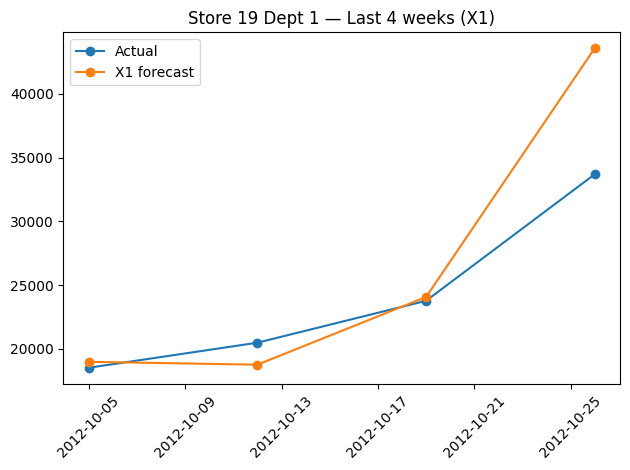

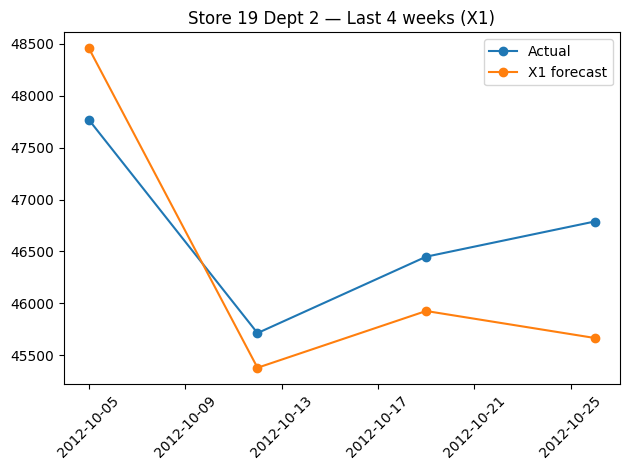

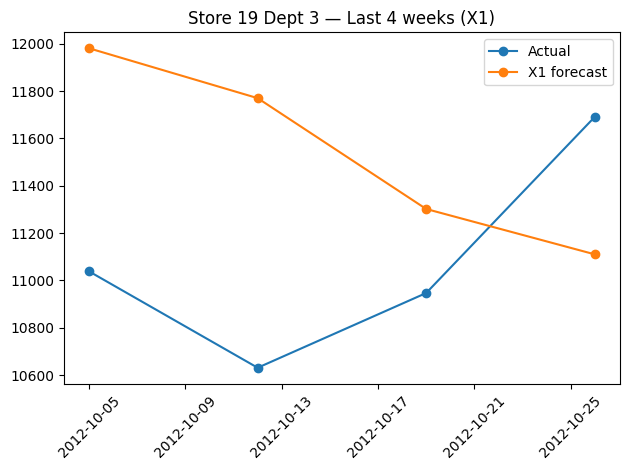

In [14]:
results_df["Date"] = pd.to_datetime(results_df["Date"])

def summarize_metrics(df, pred_col):
    y = df["y_true"].values
    yhat = df[pred_col].values
    return pd.Series({
        "MAE": mae(y, yhat),
        "RMSE": rmse(y, yhat),
        "WAPE_%": wape(y, yhat),
        "N": len(df)
    })

print("\nOverall metrics for X1:")
print(summarize_metrics(results_df, "yhat_x1"))

print("\nMetrics by store for X1:")
by_store_x1 = results_df.groupby("Store").apply(lambda g: summarize_metrics(g, "yhat_x1"))
print(by_store_x1.sort_values("WAPE_%"))

# Plot a few example depts
import matplotlib.pyplot as plt

example = results_df[(results_df["Store"] == top_3_stores[0])].copy()
example_depts = example["Dept"].drop_duplicates().head(3).tolist()
example = example[example["Dept"].isin(example_depts)]

for (s, d), g in example.groupby(["Store", "Dept"]):
    g = g.sort_values("Date")
    plt.figure()
    plt.plot(g["Date"], g["y_true"], marker="o", label="Actual")
    plt.plot(g["Date"], g["yhat_x1"], marker="o", label="X1 forecast")
    plt.title(f"Store {s} Dept {d} — Last 4 weeks (X1)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Method 2 - Aggregate, forecast, deaggregate

Overview:
1.  Aggregate: Store total weekly sales
2. Forecast: Forecast Store total (Y_hat) for the 4 test weeks
3. De-aggregate: Split each Y_hat back into Dept forecasts (X2) using seasonal shares


Store total dataframe head:
   Store       Date  Store_Total_Sales
0     13 2010-02-05         1967083.63
1     13 2010-02-12         2030748.07
2     13 2010-02-19         1970027.23
3     13 2010-02-26         1817772.89
4     13 2010-03-05         1939929.20


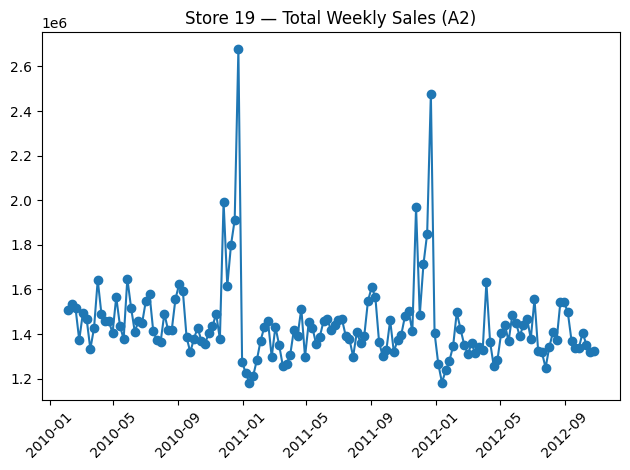

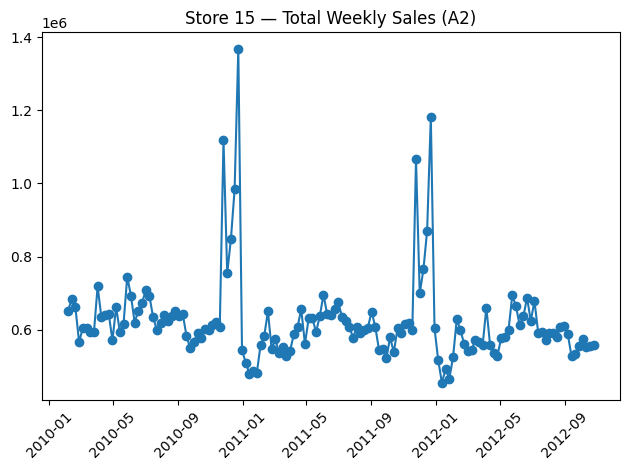

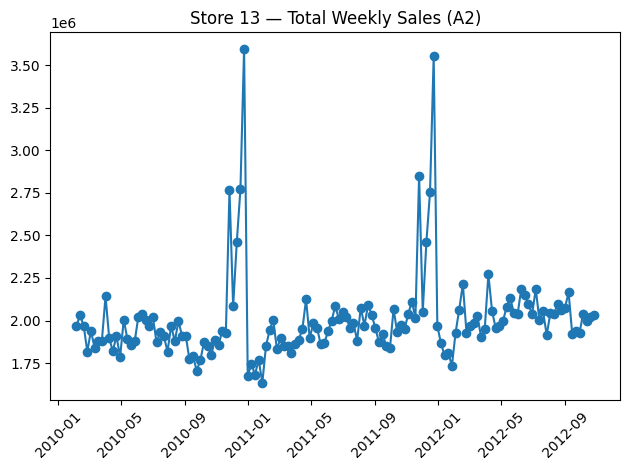

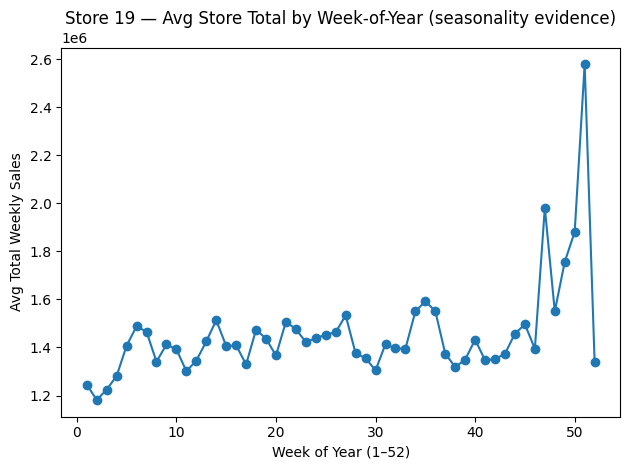

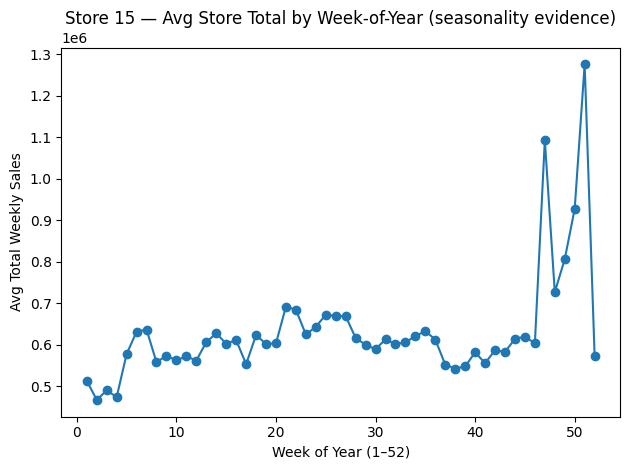

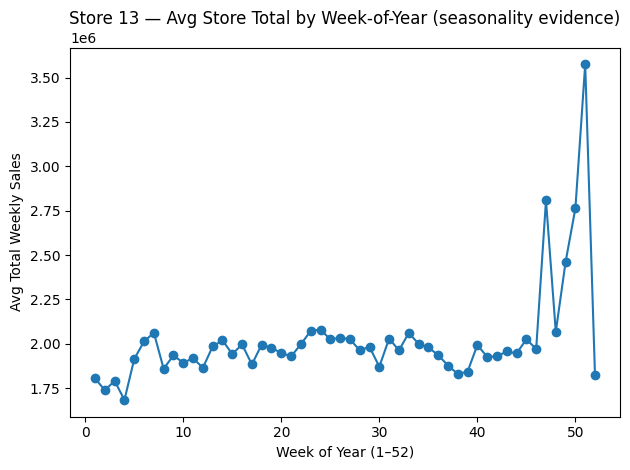

In [15]:
#Build store total series (A2) and show seasonality evidence 
import matplotlib.pyplot as plt

store_total_df = (
    train_filtered
    .groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
    .sum()
    .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
)

store_total_df["Date"] = pd.to_datetime(store_total_df["Date"])

print("Store total dataframe head:")
print(store_total_df.head())

# Plot store total time series for each of the selected stores
for store in top_3_stores:
    g = store_total_df[store_total_df["Store"] == store].sort_values("Date")
    plt.figure()
    plt.plot(g["Date"], g["Store_Total_Sales"], marker="o")
    plt.title(f"Store {store} — Total Weekly Sales (A2)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Seasonality view: average by week-of-year (1..52; week 53 mapped to 52)
store_total_df["woy"] = store_total_df["Date"].dt.isocalendar().week.astype(int)
store_total_df.loc[store_total_df["woy"] == 53, "woy"] = 52

for store in top_3_stores:
    g = store_total_df[store_total_df["Store"] == store].copy()
    seasonal_profile = g.groupby("woy")["Store_Total_Sales"].mean().reset_index()

    plt.figure()
    plt.plot(seasonal_profile["woy"], seasonal_profile["Store_Total_Sales"], marker="o")
    plt.title(f"Store {store} — Avg Store Total by Week-of-Year (seasonality evidence)")
    plt.xlabel("Week of Year (1–52)")
    plt.ylabel("Avg Total Weekly Sales")
    plt.tight_layout()
    plt.show()


Store 19 TOTAL: best (alpha,beta,gamma)=(0.2,0.3,0.5) val_MAE=38293.08087757148
Store 15 TOTAL: best (alpha,beta,gamma)=(0.4,0.1,0.5) val_MAE=12763.170171152444
Store 13 TOTAL: best (alpha,beta,gamma)=(0.2,0.1,0.1) val_MAE=66885.26625854042

Store total forecasts (Y_hat) head:
   Store       Date  y_total_true   y_total_hat
0     19 2012-10-05    1406698.10  1.418577e+06
1     19 2012-10-12    1352729.50  1.319877e+06
2     19 2012-10-19    1321102.35  1.349055e+06
3     19 2012-10-26    1322107.04  1.379632e+06
4     15 2012-10-05     573492.76  5.726073e+05

Store total forecast metrics (per store):
Store 19: MAE=32552.31, RMSE=36437.78, WAPE%=2.41, N=4
Store 15: MAE=11514.49, RMSE=17826.88, WAPE%=2.06, N=4
Store 13: MAE=37904.31, RMSE=38553.78, WAPE%=1.87, N=4


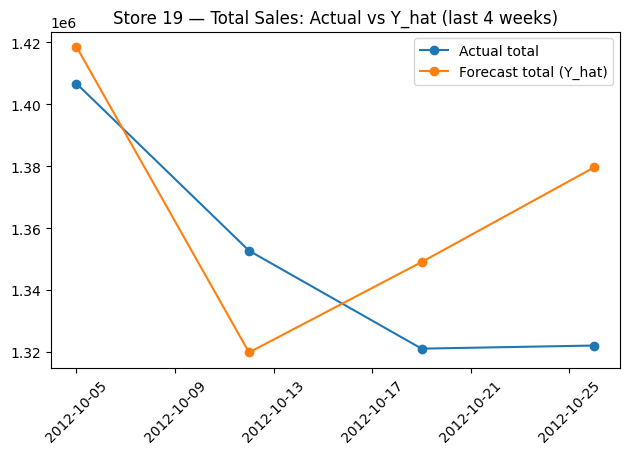

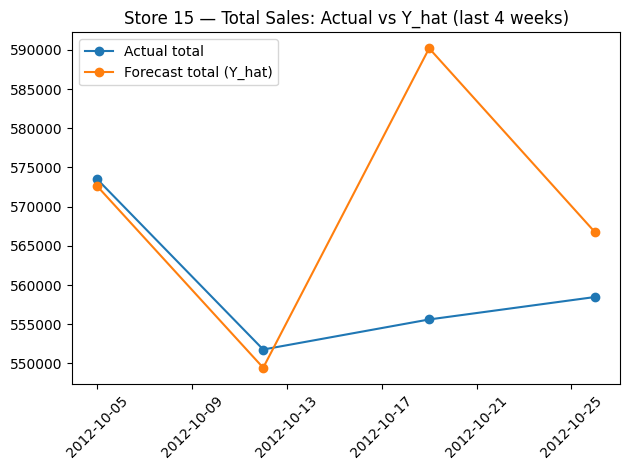

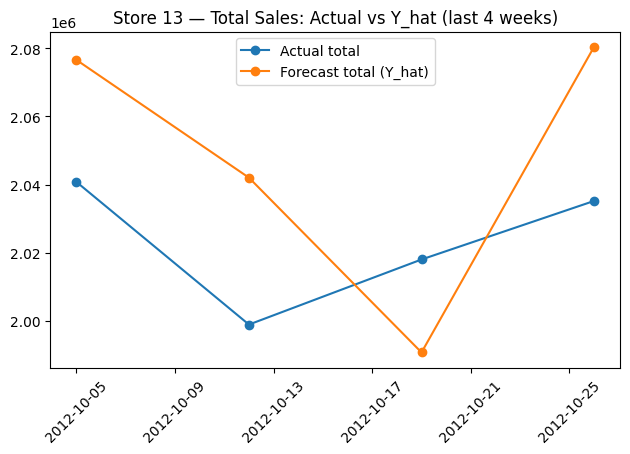

In [16]:
#Forecast Store Total (F2) to produce Y_hat

alpha_values = [0.2, 0.4, 0.6, 0.8]
beta_values  = [0.1, 0.3, 0.5]
gamma_values = [0.1, 0.3, 0.5]

store_forecasts = []  # will store Y_hat

for store in top_3_stores:
    g = store_total_df[store_total_df["Store"] == store].sort_values("Date")

    y = g["Store_Total_Sales"].values
    dates = g["Date"].values

    train_mask = ~g["Date"].isin(last_4_dates)
    test_mask  =  g["Date"].isin(last_4_dates)

    y_train = y[train_mask]
    y_test  = y[test_mask]
    test_dates = pd.to_datetime(dates[test_mask])

    if len(y_test) != len(last_4_dates):
        print(f"Skipping Store {store} store-total forecast: missing some of the last 4 test dates.")
        continue

    val_len = 8
    if len(y_train) < 52 + val_len:
        print(f"Skipping Store {store} store-total forecast: need at least {52+val_len} training points.")
        continue

    best_params, best_mae = hw_additive_grid_search(
        y_train, m=52,
        alpha_values=alpha_values,
        beta_values=beta_values,
        gamma_values=gamma_values,
        val_len=val_len
    )

    alpha_opt, beta_opt, gamma_opt = best_params
    print(f"Store {store} TOTAL: best (alpha,beta,gamma)=({alpha_opt},{beta_opt},{gamma_opt}) val_MAE={best_mae}")

    yhat_total = hw_additive_rolling_forecast(
        y_train, y_test, m=52,
        alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt
    )

    for i in range(len(y_test)):
        store_forecasts.append({
            "Store": store,
            "Date": test_dates[i],
            "y_total_true": y_test[i],
            "y_total_hat": yhat_total[i]
        })

store_forecasts_df = pd.DataFrame(store_forecasts)
store_forecasts_df["Date"] = pd.to_datetime(store_forecasts_df["Date"])

print("\nStore total forecasts (Y_hat) head:")
print(store_forecasts_df.head())

print("\nStore total forecast metrics (per store):")
for store in store_forecasts_df["Store"].unique():
    g = store_forecasts_df[store_forecasts_df["Store"] == store]
    print(f"Store {store}: MAE={mae(g['y_total_true'], g['y_total_hat']):.2f}, "
          f"RMSE={rmse(g['y_total_true'], g['y_total_hat']):.2f}, "
          f"WAPE%={wape(g['y_total_true'], g['y_total_hat']):.2f}, N={len(g)}")

# Plot store total actual vs forecast (Y)
for store in store_forecasts_df["Store"].unique():
    g = store_forecasts_df[store_forecasts_df["Store"] == store].sort_values("Date")
    plt.figure()
    plt.plot(g["Date"], g["y_total_true"], marker="o", label="Actual total")
    plt.plot(g["Date"], g["y_total_hat"], marker="o", label="Forecast total (Y_hat)")
    plt.title(f"Store {store} — Total Sales: Actual vs Y_hat (last 4 weeks)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
#De-aggregate (D2): seasonal shares -> X2 forecasts 

# Create a training-only dataframe for share estimation
train_only = train_filtered[~train_filtered["Date"].isin(last_4_dates)].copy()
train_only["Date"] = pd.to_datetime(train_only["Date"])

# Add week-of-year (1..52; map 53->52)
train_only["woy"] = train_only["Date"].dt.isocalendar().week.astype(int)
train_only.loc[train_only["woy"] == 53, "woy"] = 52

# We will create X2 forecasts aligned to store_forecasts_df (which contains Y_hat)
x2_rows = []

for store in top_3_stores:
    # store-level forecast table for test weeks
    sf = store_forecasts_df[store_forecasts_df["Store"] == store].copy()
    if sf.empty:
        print(f"Store {store}: no store-total forecasts available, skipping X2.")
        continue

    # departments to forecast (match the universe used in train_filtered)
    store_depts = sorted(train_filtered[train_filtered["Store"] == store]["Dept"].unique().tolist())

    # Build store total per (Date, woy) on training for share computation
    store_train = train_only[train_only["Store"] == store].copy()
    if store_train.empty:
        print(f"Store {store}: training-only data empty after split, skipping X2.")
        continue

    store_total_train = (
        store_train.groupby(["Date", "woy"], as_index=False)["Weekly_Sales"]
        .sum()
        .rename(columns={"Weekly_Sales": "store_total"})
    )

    # Dept sales on training by (Dept, Date, woy)
    dept_train = (
        store_train.groupby(["Dept", "Date", "woy"], as_index=False)["Weekly_Sales"]
        .sum()
        .rename(columns={"Weekly_Sales": "dept_sales"})
    )

    # Merge to compute share = dept_sales / store_total
    merged = dept_train.merge(store_total_train, on=["Date", "woy"], how="left")
    merged["share"] = np.where(
        merged["store_total"] != 0,
        merged["dept_sales"] / merged["store_total"],
        np.nan
    )

    # Overall fallback share across all training weeks:
    overall_dept_sum = merged.groupby("Dept")["dept_sales"].sum()
    overall_store_sum = store_total_train["store_total"].sum()
    if overall_store_sum == 0:
        # Fallback: uniform distribution if store sum is 0 (rare edge case)
        overall_share = pd.Series(1.0 / len(store_depts), index=store_depts)
    else:
        overall_share = (overall_dept_sum / overall_store_sum).reindex(store_depts).fillna(0.0)

    # Seasonal share: avg share per (Dept, woy)
    seasonal_share = (
        merged.groupby(["Dept", "woy"])["share"]
        .mean()
        .reset_index()
    )

    # Pivot to matrix: rows=woy, cols=Dept
    share_mat = seasonal_share.pivot(index="woy", columns="Dept", values="share")

    # Ensure all depts exist as columns
    for d in store_depts:
        if d not in share_mat.columns:
            share_mat[d] = np.nan
    share_mat = share_mat[store_depts].sort_index()

    # For each test date: pick woy, get share vector, renormalize, fallback if needed
    sf["woy"] = sf["Date"].dt.isocalendar().week.astype(int)
    sf.loc[sf["woy"] == 53, "woy"] = 52

    for _, row in sf.iterrows():
        date = row["Date"]
        woy = int(row["woy"])
        yhat_total = float(row["y_total_hat"])

        if woy in share_mat.index:
            w = share_mat.loc[woy].copy()
        else:
            w = pd.Series(np.nan, index=store_depts)

        # Replace missing with 0 then check sum
        w = w.fillna(0.0)

        if w.sum() == 0:
            w = overall_share.copy()
        else:
            w = w / w.sum()

        # Create dept-level forecasts
        for dept in store_depts:
            x2_rows.append({
                "Store": store,
                "Dept": dept,
                "Date": date,
                "yhat_x2": float(w.loc[dept] * yhat_total)
            })

x2_df = pd.DataFrame(x2_rows)
x2_df["Date"] = pd.to_datetime(x2_df["Date"])

print("\nX2 (de-aggregated) forecasts head:")
print(x2_df.head())

print("\nCoverage check (X2):")
print(x2_df.groupby(["Store", "Dept"])["Date"].nunique().value_counts())




X2 (de-aggregated) forecasts head:
   Store  Dept       Date       yhat_x2
0     19     1 2012-10-05  19679.529486
1     19     2 2012-10-05  50600.088669
2     19     3 2012-10-05  12161.277476
3     19     4 2012-10-05  32481.186566
4     19     5 2012-10-05  28715.405961

Coverage check (X2):
Date
4    211
Name: count, dtype: int64



Comparison dataframe head:
   Store  Dept       Date    y_true       yhat_x1       yhat_x2
0     19     1 2012-10-05  18526.20  18991.905854  19679.529486
1     19     1 2012-10-12  20489.20  18766.602711  20384.666417
2     19     1 2012-10-19  23772.27  24068.862156  24589.857782
3     19     1 2012-10-26  33686.67  43557.993143  41579.136331
4     19     2 2012-10-05  47767.58  48456.436558  50600.088669

Coverage check (comparison):
Date
4    210
Name: count, dtype: int64

Overall metrics: X1 vs X2
X1: MAE       1574.844174
RMSE      3128.047763
WAPE_%       8.407313
N          840.000000
dtype: float64
X2: MAE       1595.190924
RMSE      3036.817892
WAPE_%       8.515934
N          840.000000
dtype: float64

Metrics by store: X1 vs X2
   Store Method          MAE         RMSE     WAPE_%      N
0     13     X1  2000.854827  3924.959283   7.120455  288.0
1     13     X2  2052.280718  3730.725600   7.303465  288.0
2     15     X1   932.737239  1607.504885  11.496022  276.0
3     15 

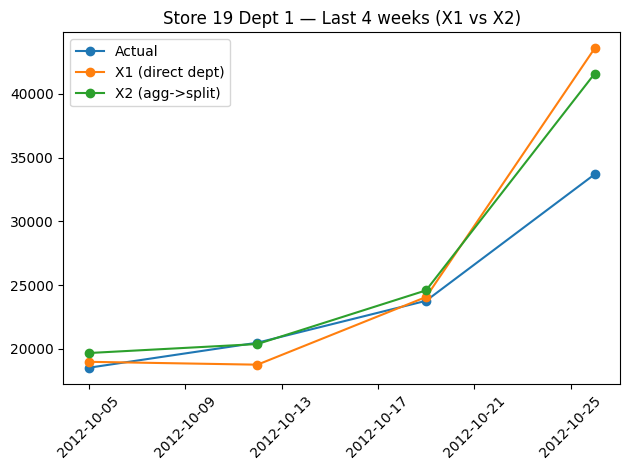

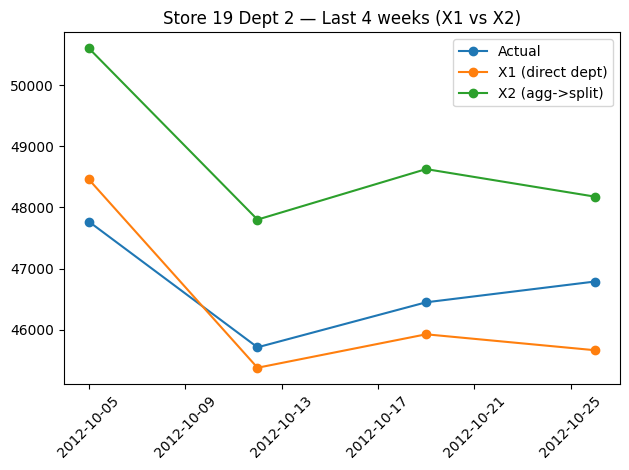

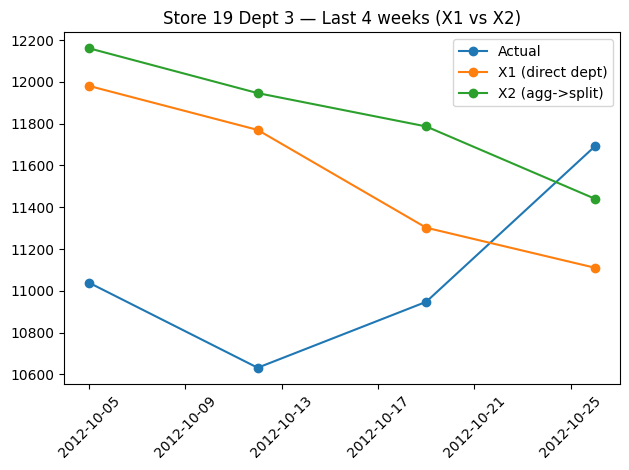

In [18]:
#Compare X1 vs X2 on the intersection of available forecasts

comparison_df = results_df.merge(
    x2_df, on=["Store", "Dept", "Date"], how="inner"
)

print("\nComparison dataframe head:")
print(comparison_df.head())

print("\nCoverage check (comparison):")
print(comparison_df.groupby(["Store", "Dept"])["Date"].nunique().value_counts())

print("\nOverall metrics: X1 vs X2")
print("X1:", summarize_metrics(comparison_df, "yhat_x1"))
print("X2:", summarize_metrics(comparison_df, "yhat_x2"))

print("\nMetrics by store: X1 vs X2")
by_store = []
for store in sorted(comparison_df["Store"].unique()):
    g = comparison_df[comparison_df["Store"] == store]
    m1 = summarize_metrics(g, "yhat_x1")
    m2 = summarize_metrics(g, "yhat_x2")
    out = pd.DataFrame([m1, m2], index=["X1", "X2"])
    out["Store"] = store
    by_store.append(out.reset_index().rename(columns={"index": "Method"}))

by_store_df = pd.concat(by_store, ignore_index=True)
print(by_store_df[["Store", "Method", "MAE", "RMSE", "WAPE_%", "N"]].sort_values(["Store", "Method"]))

# Plot actual vs X1 vs X2 for a few example depts
example = comparison_df[(comparison_df["Store"] == top_3_stores[0])].copy()
example_depts = example["Dept"].drop_duplicates().head(3).tolist()
example = example[example["Dept"].isin(example_depts)]

for (s, d), g in example.groupby(["Store", "Dept"]):
    g = g.sort_values("Date")
    plt.figure()
    plt.plot(g["Date"], g["y_true"], marker="o", label="Actual")
    plt.plot(g["Date"], g["yhat_x1"], marker="o", label="X1 (direct dept)")
    plt.plot(g["Date"], g["yhat_x2"], marker="o", label="X2 (agg->split)")
    plt.title(f"Store {s} Dept {d} — Last 4 weeks (X1 vs X2)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Conclusion of Part I

We will first give you an overview of the methods again. We are only taking 3 stores (13, 15, 19) for this experiment to reduce computation time.

With method 1, for each (Store, Dept) series, we split into training (all except last 4 weeks) and test (last 4 weeks), then tune TSE parameters using a rolling 1-step validation (val length = 8) inside training, and fit on the full training data and produce rolling 1-step forecasts for the 4 test weeks, and collect the dept level forecasts (X1).

We implemented additive over multiplicative since weekly sales can be zero or negaive (returns).

With method 2, for each Store, we first aggregate weekly sales across all departments to get Store total weekly sales. Then we split into training (all except last 4 weeks) and test (last 4 weeks), then tune TSE parameters using a rolling 1-step validation (val length = 8) inside training, and fit on the full training data and produce rolling 1-step forecasts for the 4 test weeks to get Store total forecasts (Y_hat). Finally we split each Y_hat back into Dept forecasts (X2) using seasonal shares calculated from the training data.

### Results:

**Overall (840 dept-level test points)**
X₁ (Method 1):
* MAE 1574.84
* RMSE 3128.05
* WAPE 8.41%
X₂ (Method 2):
* MAE 1595.19
* RMSE 3036.82
* WAPE 8.52%

So Method 1 is slightly better in MAE and WAPE, while Method 2 is slightly better on RMSE (fewer very large errors), but its average % error is a bit worse. 

**By store (WAPE%)**
* Store 13: X₁ 7.12% vs X₂ 7.30% -> Method 1 better
* Store 19: X₁ 9.05% vs X₂ 9.16% -> Method 1 better
* Store 15: X₁ 11.50% vs X₂ 11.34% -> Method 2 better (small improvement)

So Method 1 is better at dept-level forecasting approach as it is better overall on WAPE and MAE. 
Method 2 produces excellent store-total forecasts, but the de-aggregation step adds errors at department level, making $X_2$ slightly worse overall. 
The key trade-off is that aggregation helps forecasting with smooth series and clear seasonality, but splitting forecasts back into departments can be imperfect when department shares change.

## Part II - To maximize changes of getting a rebate laid out in contract between store and supplier

Weekday distribution of Date labels (whole dataset):
Date
Friday    6435
Name: count, dtype: int64

Top 10 stores by |lag-52 correlation| (seasonality strength):
   Store  lag52_corr  abs_lag52_corr
0     41    0.949517        0.949517
1     16    0.940536        0.940536
2     32    0.940006        0.940006
3     10    0.935742        0.935742
4      8    0.935363        0.935363
5     15    0.934071        0.934071
6      7    0.928649        0.928649
7      4    0.925210        0.925210
8     12    0.923344        0.923344
9     34    0.920397        0.920397

Chosen STORE_ID for Part II: 41

Chosen store date range:
2010-02-05 00:00:00 to 2012-10-26 00:00:00  | weeks: 143

Date diffs value counts (chosen store):
Date
7 days    142
Name: count, dtype: int64

Weekday of Date label (chosen store):
Date
Friday    143
Name: count, dtype: int64

Weekday of computed week_start (chosen store):
week_start
Saturday    143
Name: count, dtype: int64


/tmp/ipykernel_296035/632421585.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lag52_corr)


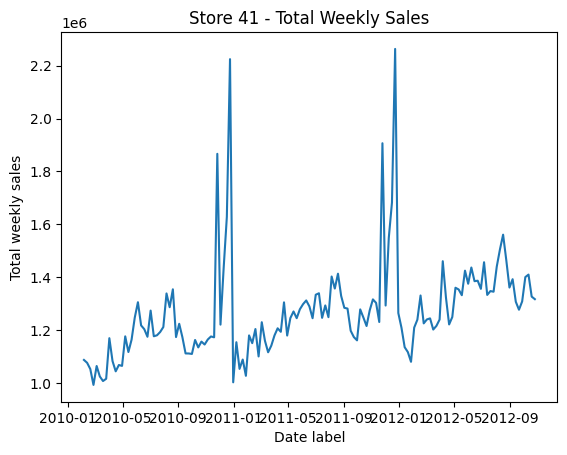

In [19]:
# Ensure Date is datetime
train["Date"] = pd.to_datetime(train["Date"])

# Build store-total weekly sales series: A_t = sum_dept Weekly_Sales
store_total_all = (
    train.groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
         .sum()
         .rename(columns={"Weekly_Sales": "Store_Total_Sales"})
     .sort_values(["Store", "Date"])
     .reset_index(drop=True)
)

# Check the weekday of the Date labels (this dataset typically uses a fixed weekday)
weekday_counts = store_total_all["Date"].dt.day_name().value_counts()
print("Weekday distribution of Date labels (whole dataset):")
print(weekday_counts)

# For each store: compute a simple seasonality score using lag-52 correlation on totals
def lag52_corr(df_one_store):
    y = df_one_store["Store_Total_Sales"].values.astype(float)
    if len(y) < 120:  # strict minimum for a meaningful lag-52 correlation
        return np.nan
    y0 = y[52:]
    y1 = y[:-52]
    if np.std(y0) == 0 or np.std(y1) == 0:
        return np.nan
    return np.corrcoef(y0, y1)[0, 1]

scores = (
    store_total_all.groupby("Store")
    .apply(lag52_corr)
    .rename("lag52_corr")
    .reset_index()
)

scores["abs_lag52_corr"] = scores["lag52_corr"].abs()
scores = scores.sort_values("abs_lag52_corr", ascending=False).reset_index(drop=True)

print("\nTop 10 stores by |lag-52 correlation| (seasonality strength):")
print(scores.head(10))

# Pick the best store deterministically: highest |lag-52 corr|
STORE_ID = int(scores.loc[0, "Store"])
print(f"\nChosen STORE_ID for Part II: {STORE_ID}")

# Extract chosen store series
s = store_total_all[store_total_all["Store"] == STORE_ID].copy()
s = s.sort_values("Date").reset_index(drop=True)

print("\nChosen store date range:")
print(s["Date"].min(), "to", s["Date"].max(), " | weeks:", len(s))

# Check weekly spacing (must be 7 days)
diffs = s["Date"].diff().dropna()
print("\nDate diffs value counts (chosen store):")
print(diffs.value_counts().head(10))

if not (diffs == pd.Timedelta(days=7)).all():
    bad = s.loc[diffs != pd.Timedelta(days=7), ["Date"]].head(20)
    raise ValueError(
        "Found non-7-day gaps in the chosen store series. "
        "Paste the printed diffs and sample dates here.\n"
        f"{bad}"
    )

# Define week_start for the contract month assignment:
# Your data labels a weekly point with a fixed weekday (commonly Friday = week-ending).
# The first day of that week is (Date - 6 days).
s["week_start"] = s["Date"] - pd.Timedelta(days=6)

print("\nWeekday of Date label (chosen store):")
print(s["Date"].dt.day_name().value_counts())

print("\nWeekday of computed week_start (chosen store):")
print(s["week_start"].dt.day_name().value_counts())

# Month membership uses the first day of the week
s["month_id"] = s["week_start"].dt.to_period("M")

# Quick plot of store total series
plt.figure()
plt.plot(s["Date"], s["Store_Total_Sales"])
plt.title(f"Store {STORE_ID} - Total Weekly Sales")
plt.xlabel("Date label")
plt.ylabel("Total weekly sales")
plt.show()


In [20]:
# =========================
# Part II - Contract helpers (horizon-2 = 2 weeks ahead from issue week)
# In this contract timing, at the beginning of week w you know actuals through week w-1.
# The forecast for week w+2 is therefore 3 steps ahead from the last known point.
# =========================

def hw_additive_forecast_from_state(level, trend, seasonal, n_obs, m, h_steps):
    """
    Multi-step forecast for additive Holt-Winters.
    - n_obs: number of observations already incorporated into the state
    - h_steps: 1 -> forecast for index n_obs (next)
               2 -> forecast for index n_obs+1
               3 -> forecast for index n_obs+2
    """
    idx = (n_obs + (h_steps - 1)) % m
    return level + h_steps * trend + seasonal[idx]

def hw_additive_update_state(level, trend, seasonal, alpha, beta, gamma, y_t, t_index, m):
    """
    One-step state update at absolute time index t_index (0-based).
    Matches your update equations from holt_winters_additive.
    """
    idx = t_index % m
    old_level = level
    old_trend = trend
    old_seasonal = seasonal[idx]

    level = alpha * (y_t - old_seasonal) + (1 - alpha) * (old_level + old_trend)
    trend = beta * (level - old_level) + (1 - beta) * old_trend
    seasonal[idx] = gamma * (y_t - level) + (1 - gamma) * old_seasonal

    return level, trend, seasonal

def contract_h2_backtest_table(dates, y, alpha, beta, gamma, m):
    """
    Build the contract horizon-2 forecast table for a single weekly series.
    Output rows correspond to: issue_week -> target_week (issue+2 weeks).
    With contract timing, the horizon-2 target is 3 steps ahead from last known actual.

    Returns DataFrame with:
      issue_date, target_date, y_true, yhat, issue_idx, target_idx
    """
    dates = pd.to_datetime(pd.Series(dates)).reset_index(drop=True)
    y = np.asarray(y, dtype=float)

    if len(y) < 2*m + 10:
        raise ValueError(
            f"Need more history for stable yearly seasonality (m={m}). "
            f"Got only {len(y)} points. Paste this message and your store length here."
        )

    init_len = 2 * m  # stable init for yearly seasonality
    y_init = y[:init_len]

    # Fit once on initial window to get states after observing index init_len-1
    _, level, trend, seasonal = holt_winters_additive(y_init, alpha, beta, gamma, m)

    rows = []

    # last known index t_known runs until we can still hit target = t_known+3
    # (3 steps ahead from last known corresponds to contract horizon-2)
    for t_known in range(init_len - 1, len(y) - 3):
        issue_idx = t_known + 1
        target_idx = t_known + 3  # issue+2 weeks

        # Forecast 3 steps ahead from last known
        yhat = hw_additive_forecast_from_state(level, trend, seasonal, n_obs=t_known + 1, m=m, h_steps=3)
        ytrue = y[target_idx]

        rows.append({
            "issue_idx": issue_idx,
            "target_idx": target_idx,
            "issue_date": dates.iloc[issue_idx],
            "target_date": dates.iloc[target_idx],
            "y_true": ytrue,
            "yhat": yhat
        })

        # Move forward one observed week: incorporate y[t_known+1]
        y_next = y[t_known + 1]
        level, trend, seasonal = hw_additive_update_state(
            level, trend, seasonal, alpha, beta, gamma, y_next, t_index=t_known + 1, m=m
        )

    return pd.DataFrame(rows)


In [21]:
# =========================
# Part II - Train/val split + parameter tuning for contract horizon-2
# =========================

# Use yearly seasonality for weekly data
M = 52

# Reserve last 4 weeks as project evaluation holdout (as in Part I)
s_model = s.iloc[:-4].copy().reset_index(drop=True)
s_holdout = s.iloc[-4:].copy().reset_index(drop=True)

print("\nModeling end (excluding last 4 weeks):", s_model["Date"].max())
print("Holdout dates (last 4):")
print(s_holdout["Date"].tolist())

y_all = s_model["Store_Total_Sales"].values.astype(float)
d_all = s_model["Date"].values

# Validation length (matches your Part I style, keeps compute light)
VAL_LEN = 8

if len(y_all) < 2*M + VAL_LEN + 10:
    raise ValueError(
        f"Not enough points after excluding last 4 weeks for m={M} and val_len={VAL_LEN}. "
        f"Got {len(y_all)} points."
    )

# Define tuning split
y_fit = y_all[:-VAL_LEN]
d_fit = d_all[:-VAL_LEN]
y_val = y_all[-VAL_LEN:]
d_val = d_all[-VAL_LEN:]

# Parameter grid (same grid size style as your Part I)
alpha_values = [0.2, 0.4, 0.6, 0.8]
beta_values  = [0.1, 0.3, 0.5]
gamma_values = [0.1, 0.3, 0.5]

best = None
best_mae = np.inf

for a in alpha_values:
    for b in beta_values:
        for g in gamma_values:
            bt = contract_h2_backtest_table(
                dates=np.concatenate([d_fit, d_val]),
                y=np.concatenate([y_fit, y_val]),
                alpha=a, beta=b, gamma=g, m=M
            )

            # Validation targets are those whose target_idx falls inside the val segment
            start_val_idx = len(y_fit)
            bt_val = bt[bt["target_idx"] >= start_val_idx].copy()

            if len(bt_val) == 0:
                continue

            score = mae(bt_val["y_true"].values, bt_val["yhat"].values)

            if score < best_mae:
                best_mae = score
                best = (a, b, g)

print("\nBest TES params for contract horizon-2 (by validation MAE):")
print("alpha, beta, gamma =", best, " | val_MAE =", best_mae)



Modeling end (excluding last 4 weeks): 2012-09-28 00:00:00
Holdout dates (last 4):
[Timestamp('2012-10-05 00:00:00'), Timestamp('2012-10-12 00:00:00'), Timestamp('2012-10-19 00:00:00'), Timestamp('2012-10-26 00:00:00')]

Best TES params for contract horizon-2 (by validation MAE):
alpha, beta, gamma = (0.2, 0.1, 0.5)  | val_MAE = 31187.826949721755


In [22]:
# =========================
# Part II - Baseline backtest + rho_m + X bracket for last 12 months
# =========================

alpha_star, beta_star, gamma_star = best

bt_base = contract_h2_backtest_table(
    dates=s_model["Date"].values,
    y=s_model["Store_Total_Sales"].values,
    alpha=alpha_star, beta=beta_star, gamma=gamma_star, m=M
)

# Month membership uses FIRST day of the target week
bt_base["week_start_target"] = pd.to_datetime(bt_base["target_date"]) - pd.Timedelta(days=6)
bt_base["month_id"] = bt_base["week_start_target"].dt.to_period("M")

# Define "past year" as the last 12 months available in the modeling period
last_month = bt_base["month_id"].max()
start_month = (last_month - 11)

bt_year = bt_base[(bt_base["month_id"] >= start_month) & (bt_base["month_id"] <= last_month)].copy()

# Monthly sums and rho
monthly_base = (
    bt_year.groupby("month_id")
    .agg(F_sum=("yhat", "sum"), A_sum=("y_true", "sum"))
    .reset_index()
)

monthly_base["rho"] = (monthly_base["F_sum"] - monthly_base["A_sum"]) / monthly_base["A_sum"].replace(0, np.nan)
monthly_base["abs_rho"] = monthly_base["rho"].abs()

# X bracket: pick X so that about half the months qualify
X = np.nanmedian(monthly_base["abs_rho"].values)

monthly_base["qualifies"] = monthly_base["abs_rho"] <= X

print("\nBaseline monthly rebate KPI table (last 12 months):")
print(monthly_base)

print("\nChosen X (median |rho| over last 12 months):", X)
print("Baseline qualifying months:", int(monthly_base["qualifies"].sum()), "out of", len(monthly_base))

# Weekly accuracy of horizon-2 forecasts over the same year
y_true_year = bt_year["y_true"].values
y_hat_year  = bt_year["yhat"].values

print("\nBaseline weekly accuracy over last 12 months (horizon-2 targets):")
print("MAE :", mae(y_true_year, y_hat_year))
print("RMSE:", rmse(y_true_year, y_hat_year))
print("WAPE%:", wape(y_true_year, y_hat_year))



Baseline monthly rebate KPI table (last 12 months):
  month_id         F_sum       A_sum       rho   abs_rho  qualifies
0  2012-02  3.441406e+06  3795180.38 -0.093217  0.093217      False
1  2012-03  6.067830e+06  6360338.27 -0.045989  0.045989      False
2  2012-04  5.262940e+06  5152541.44  0.021426  0.021426       True
3  2012-05  5.702668e+06  5484191.37  0.039837  0.039837      False
4  2012-06  7.242497e+06  7019276.50  0.031801  0.031801       True
5  2012-07  5.719686e+06  5464101.32  0.046775  0.046775      False
6  2012-08  5.746190e+06  5890116.36 -0.024435  0.024435       True
7  2012-09  5.241952e+06  5283325.44 -0.007831  0.007831       True

Chosen X (median |rho| over last 12 months): 0.0358192337874044
Baseline qualifying months: 4 out of 8

Baseline weekly accuracy over last 12 months (horizon-2 targets):
MAE : 60383.79136551646
RMSE: 75521.81908950931
WAPE%: 4.483029828622558


In [23]:
# =========================
# Part II - Strategy: rolling bias correction at issue time
# Uses only errors from targets that would be known at the time the forecast is issued.
# =========================

bt_adj = bt_year.copy().sort_values("target_idx").reset_index(drop=True)

K = 8  # rolling window length in weeks for bias estimation

adj_list = []

for i in range(len(bt_adj)):
    t = int(bt_adj.loc[i, "target_idx"])

    # At issue week (t-2), known actuals go through week (t-3)
    max_known_target = t - 3

    past = bt_base[(bt_base["target_idx"] <= max_known_target)].copy()
    past = past.sort_values("target_idx")

    # Keep last K known targets
    past = past.tail(K)

    sum_a = past["y_true"].sum()
    if sum_a == 0 or len(past) == 0:
        bias = 0.0
    else:
        bias = (past["yhat"].sum() - past["y_true"].sum()) / sum_a

    yhat_raw = float(bt_adj.loc[i, "yhat"])
    yhat_new = yhat_raw / (1.0 + bias)

    adj_list.append(yhat_new)

bt_adj["yhat_adj"] = adj_list

# Recompute monthly rho with adjusted forecasts under the SAME X
monthly_adj = (
    bt_adj.groupby("month_id")
    .agg(F_sum=("yhat_adj", "sum"), A_sum=("y_true", "sum"))
    .reset_index()
)

monthly_adj["rho_adj"] = (monthly_adj["F_sum"] - monthly_adj["A_sum"]) / monthly_adj["A_sum"].replace(0, np.nan)
monthly_adj["abs_rho_adj"] = monthly_adj["rho_adj"].abs()
monthly_adj["qualifies_adj"] = monthly_adj["abs_rho_adj"] <= X

# Merge baseline vs adjusted month-by-month
month_compare = monthly_base.merge(
    monthly_adj[["month_id", "rho_adj", "abs_rho_adj", "qualifies_adj"]],
    on="month_id",
    how="inner"
)

print("\nMonth-by-month comparison (baseline vs adjusted):")
print(month_compare)

base_n = int(month_compare["qualifies"].sum())
adj_n  = int(month_compare["qualifies_adj"].sum())

print("\nQualifying months (baseline):", base_n, "out of", len(month_compare))
print("Qualifying months (adjusted):", adj_n, "out of", len(month_compare))
print("Extra rebate months gained:", adj_n - base_n)

# Weekly accuracy loss over the same year
yhat_adj_year = bt_adj["yhat_adj"].values

print("\nAdjusted weekly accuracy over last 12 months (horizon-2 targets):")
print("MAE :", mae(y_true_year, yhat_adj_year))
print("RMSE:", rmse(y_true_year, yhat_adj_year))
print("WAPE%:", wape(y_true_year, yhat_adj_year))

print("\nAccuracy change (Adjusted - Baseline):")
print("ΔMAE :", mae(y_true_year, yhat_adj_year) - mae(y_true_year, y_hat_year))
print("ΔRMSE:", rmse(y_true_year, yhat_adj_year) - rmse(y_true_year, y_hat_year))
print("ΔWAPE%:", wape(y_true_year, yhat_adj_year) - wape(y_true_year, y_hat_year))



Month-by-month comparison (baseline vs adjusted):
  month_id         F_sum       A_sum       rho   abs_rho  qualifies   rho_adj  \
0  2012-02  3.441406e+06  3795180.38 -0.093217  0.093217      False -0.093217   
1  2012-03  6.067830e+06  6360338.27 -0.045989  0.045989      False  0.058169   
2  2012-04  5.262940e+06  5152541.44  0.021426  0.021426       True  0.086869   
3  2012-05  5.702668e+06  5484191.37  0.039837  0.039837      False  0.057817   
4  2012-06  7.242497e+06  7019276.50  0.031801  0.031801       True  0.009213   
5  2012-07  5.719686e+06  5464101.32  0.046775  0.046775      False  0.007761   
6  2012-08  5.746190e+06  5890116.36 -0.024435  0.024435       True -0.059359   
7  2012-09  5.241952e+06  5283325.44 -0.007831  0.007831       True -0.018770   

   abs_rho_adj  qualifies_adj  
0     0.093217          False  
1     0.058169          False  
2     0.086869          False  
3     0.057817          False  
4     0.009213           True  
5     0.007761           Tr

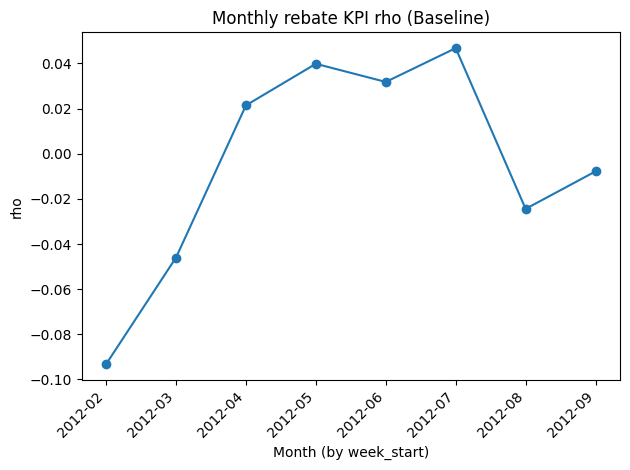

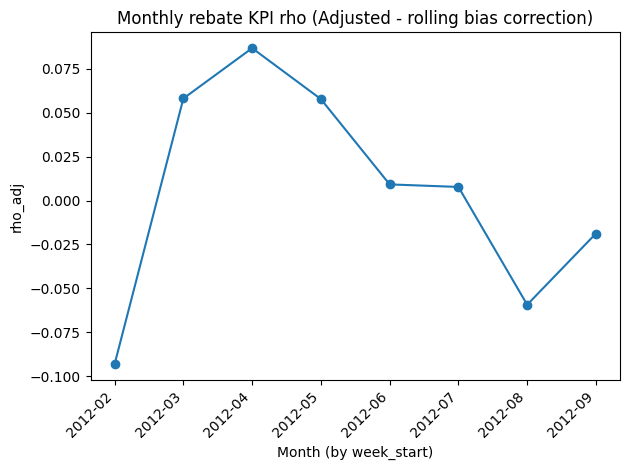

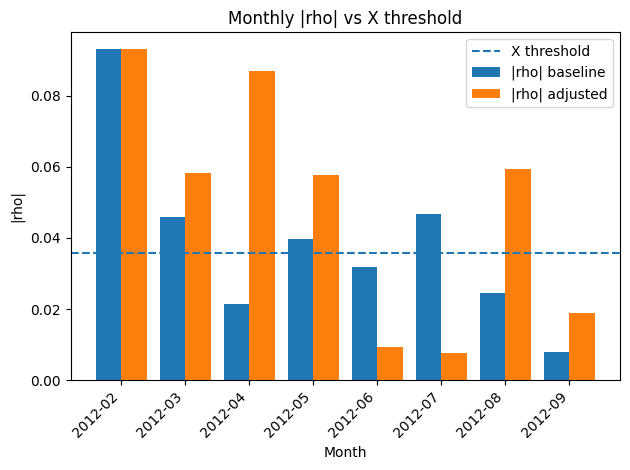

In [24]:
# =========================
# Part II - Plots for reporting
# =========================

# Plot rho by month
plt.figure()
plt.plot(month_compare["month_id"].astype(str), month_compare["rho"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Monthly rebate KPI rho (Baseline)")
plt.xlabel("Month (by week_start)")
plt.ylabel("rho")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(month_compare["month_id"].astype(str), month_compare["rho_adj"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Monthly rebate KPI rho (Adjusted - rolling bias correction)")
plt.xlabel("Month (by week_start)")
plt.ylabel("rho_adj")
plt.tight_layout()
plt.show()

# Side-by-side bars (qualifies)
plt.figure()
x = np.arange(len(month_compare))
plt.bar(x - 0.2, month_compare["abs_rho"], width=0.4, label="|rho| baseline")
plt.bar(x + 0.2, month_compare["abs_rho_adj"], width=0.4, label="|rho| adjusted")
plt.axhline(X, linestyle="--", label="X threshold")
plt.xticks(x, month_compare["month_id"].astype(str), rotation=45, ha="right")
plt.title("Monthly |rho| vs X threshold")
plt.xlabel("Month")
plt.ylabel("|rho|")
plt.legend()
plt.tight_layout()
plt.show()
